##  Импорт библиотек

In [ ]:
! pip -q install pandas pyarrow datasets lovely-tensors tensorboard wandb


In [4]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import io
import pickle
from tqdm.notebook import tqdm
from PIL import Image
from datasets import load_dataset
import cv2
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import random
import datasets
import yaml

# Сбор данных

В качестве источников данных будут использованы публичные данные, размеченные медицинским персоналом


## Импорт и разметка данных

### Датасет №1

Alzheimer MRI Disease Classification dataset is a valuable resource for researchers and health medicine applications. This dataset focuses on the classification of Alzheimer's disease based on MRI scans. The dataset consists of brain MRI images labeled into four categories:

'0': Mild_Demented

'1': Moderate_Demented

'2': Non_Demented

'3': Very_Mild_Demented

In [4]:
# Download latest version
data_train = load_dataset('Falah/Alzheimer_MRI', split='train')
data_test = load_dataset('Falah/Alzheimer_MRI', split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [5]:
print("Number of examples:", len(data_train))
print("Sample data:")
for example in data_train[:5]:
    print(example)

Number of examples: 5120
Sample data:
image
label


In [6]:
print("Number of examples:", len(data_test))
print("Sample data:")
for example in data_test[:5]:
    print(example)

Number of examples: 1280
Sample data:
image
label


### Датасет №2

чтобы компенсировать дисбаланс классов, дополним train датасет данными и выравним количество изображений в каждом классе. Для этого, аугментируем изображения классов так, чтобы количество изображений в каждом классе было равно 2500

In [7]:
# Set parameters
data_train_df = pd.DataFrame(data_train)
target_class_count = 2500
classes_to_augment = set()

# Count images in each class
class_counts = {label: 0 for label in set(data_train['label'])}
for example in data_train:
    class_counts[example['label']] += 1

# Identify classes that need augmentation
classes_to_augment = {label for label, count in class_counts.items() if count < target_class_count}

# Create a directory for augmented images if it doesn't exist
augmented_dir = 'augmented_images'
os.makedirs(augmented_dir, exist_ok=True)


Для аугментации, используем ротацию, незначительное изменение ширины и высоты изображения, приближение, горизонтальное отображение.

In [8]:
# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
def augment_images(class_label):
    class_data = [example for example in data_train if example['label'] == class_label]
    current_count = len(class_data)

    # Calculate how many more images are needed
    needed_count = target_class_count - current_count
    augmented_images = []

    for index in range(current_count):
        # Get the Image object directly from the dataset
        img = class_data[index]['image']
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generate augmented images and save them
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
            augmented_img_path = os.path.join(augmented_dir, f'class_{class_label}_aug_{index}_{i}.jpg')
            tf.keras.preprocessing.image.save_img(augmented_img_path, batch[0])
            augmented_images.append({'image': augmented_img_path, 'label': class_label})
            needed_count -= 1

            if needed_count <= 0:
                break

    return augmented_images

In [10]:
# Augment images for each class that needs it
all_augmented_images = []
for class_label in classes_to_augment:
    all_augmented_images.extend(augment_images(class_label))

# Create a new dataset from the augmented images
augmented_dataset = datasets.Dataset.from_list(all_augmented_images)

In [11]:
print("Number of examples:", len(augmented_dataset))
print("Sample data:")
for example in augmented_dataset[:5]:
    print(example)

Number of examples: 7497
Sample data:
image
label


Получаем почти 7.5 тыс дополнительных изображений.

## Интеграция данных

Теперь объединяем изначальный и аугментированный датасет. 4 класса, в каждом должно быть по 2500 изображений, таким образом финальный датасет должен содержать 10 000 изображений, которые можно использовать для обучения модели.

In [26]:
final_data_list = []
for label in set(data_train['label']):
    original_images = [example for example in data_train if example['label'] == label]
    augmented_images = [example for example in all_augmented_images if example['label'] == label]

    # Combine original and augmented images
    combined_images = original_images + augmented_images

    # Convert images to bytes
    for image_dict in combined_images:
    # If image is a PIL Image object
        if isinstance(image_dict['image'], Image.Image):
            image_bytes = io.BytesIO()
            image_dict['image'].save(image_bytes, format='JPEG')
            image_dict['image'] = image_bytes.getvalue()
        # If image is a file path (string)
        elif isinstance(image_dict['image'], str):
            with open(image_dict['image'], 'rb') as f:
                image_dict['image'] = f.read()

    # If we have more than 2500, randomly sample to get exactly 2500
    if len(combined_images) > target_class_count:
        combined_images = np.random.choice(combined_images, target_class_count, replace=False).tolist()

    final_data_list.extend(combined_images)

# Create final merged dataset with exactly 2500 images per class
final_dataset_merged = datasets.Dataset.from_list(final_data_list)
print(final_dataset_merged)

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


Рандомно перемешиваем изображения в датасете

In [14]:
# shuffle data
final_dataset_merged = final_dataset_merged.shuffle(seed=42)

In [40]:
type(final_dataset_merged)

datasets.arrow_dataset.Dataset

# Очистка данных

Для удобства, конвертируем датасет в датафрейм. Как видно, пропусков в датасете нет, распределение классов равномерно и без аномалий

In [15]:
print(final_dataset_merged.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Value(dtype='binary', id=None), 'label': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)


In [16]:
final_dataset_merged_df = pd.DataFrame(final_dataset_merged)

In [17]:
final_dataset_merged_df.isna().sum()

,0
image,0
label,0


In [18]:
final_dataset_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [19]:
final_dataset_merged_df.head(5)

,image,label
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1


array([[<Axes: title={'center': 'label'}>]], dtype=object)

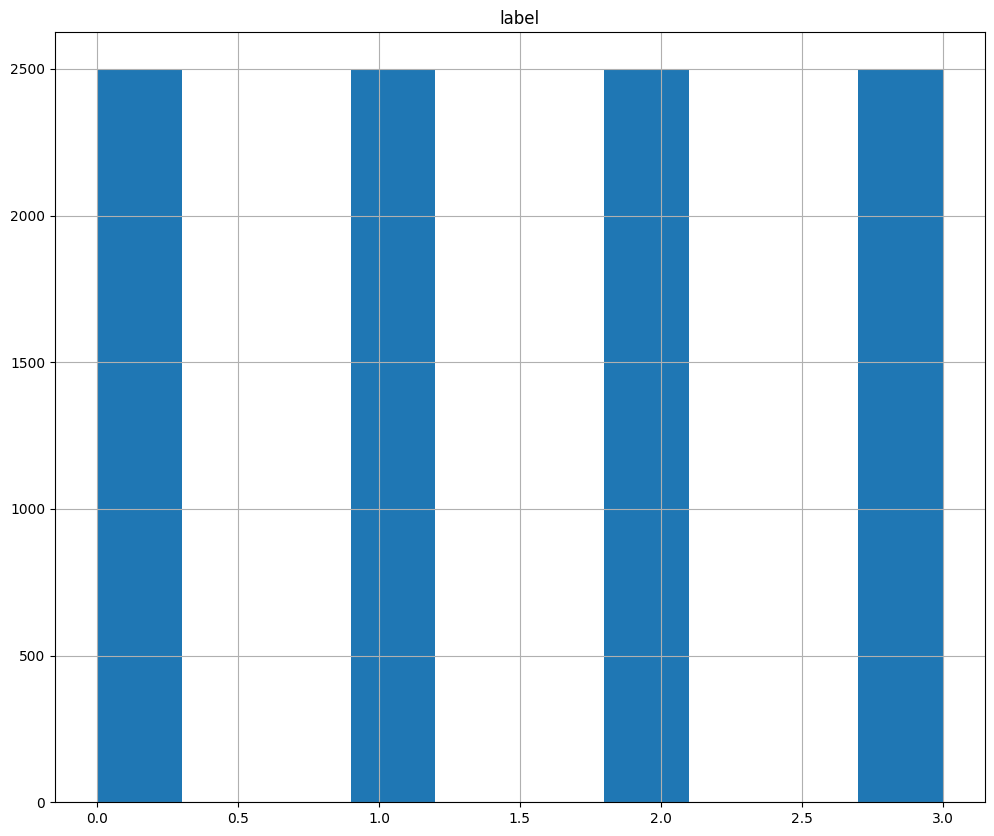

In [20]:
final_dataset_merged_df.hist(figsize=(12, 10))

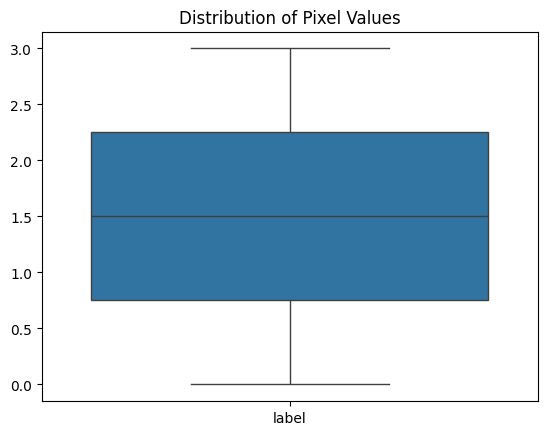

In [21]:
data = final_dataset_merged
sns.boxplot(data=final_dataset_merged)
plt.title("Distribution of Pixel Values")
plt.show()

# Предобработка данных:

Трансформироем изображения в вектор для последующего обучения модели. Стандартизируем формат изображения (RGB). Нормализуем данные с помощью функции transform.


In [22]:
class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']

        # Convert PIL image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
train_dataset = AlzheimerDataset(final_dataset_merged, transform=transform)

Получаем датасет, содержащий вектора RGB изображений

# Хранение данных

**SQLite база данных:**

Ключевые особенности:
- Эффективное хранение BLOB для тензоров
- Пакетная обработка для больших наборов данных
- Хранение метаданных
- Индикаторы прогресса для длительных операций
- Эффективная загрузка

Преимущества:
- Постоянное хранение
- Индексы базы для быстрого извлечения
- Отслеживание метаданных
- Управление памятью

Формат хранения:
Тензоры хранятся в виде двоичных BLOB. Метки хранятся в виде целых чисел. Информация о форме и типе данных сохраняется. Есть временные метки для отслеживания

In [46]:
from database import TensorDatabaseManager

def save_to_database(processed_data):
    db = TensorDatabaseManager()
    db.save_dataset(processed_data)

save_to_database(final_dataset_merged)

Saving dataset to database...


  0%|          | 0/10 [00:00<?, ?it/s]

Successfully saved 10000 samples to database

Dataset metadata:


# Анализ данных и визуализация

Провести анализ данных для выявления инсайтов и паттернов.
    
Построить визуализации для представления результатов анализа.
    
Подготовить отчет с рекомендациями по улучшению бизнес-процессов.


Визуализируем изначальный и новый интегрированный даасет. Видно, что изображения стали более вариативными. Распределение классов выровнялось, что облегчит обучение модели.

In [30]:
# Data Analysis Functions
def analyze_class_distribution(dataset, save_to_yaml='class_distribution.yaml'):
    labels = [sample['label'] for sample in dataset]
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    plt.savefig('class_distribution.png')
    plt.close()

    # Save class distribution data to YAML file
    class_distribution = dict(zip(unique_labels, counts))
    with open(save_to_yaml, 'w') as yaml_file:
        yaml.dump(class_distribution, yaml_file)

    return class_distribution

def show_sample_images(dataset, num_samples=5, save_to_png='Dashboard/sample_images.png'):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(dataset[i]['image'])
        axes[i].set_title(f"Class: {dataset[i]['label']}")
        axes[i].axis('off')
    plt.show()

    plt.savefig(save_to_png)
    plt.close()


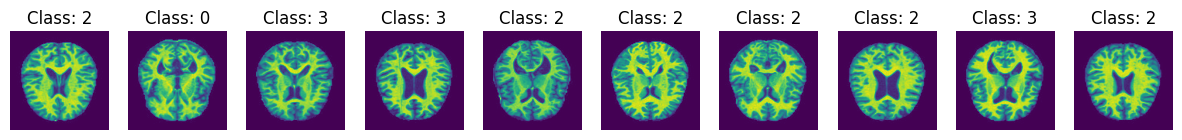

In [31]:
show_sample_images(data_train, 10)

In [33]:
def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        # Check if 'image' is bytes and convert to PIL Image
        if isinstance(dataset[i]['image'], bytes):
            image = Image.open(io.BytesIO(dataset[i]['image']))
        # Check if 'image' is a file path and open it
        elif isinstance(dataset[i]['image'], str):
            image = Image.open(dataset[i]['image'])
        else: # Assume it is a PIL image if not the above
            image = dataset[i]['image']

        axes[i].imshow(image) # Display the PIL image
        axes[i].set_title(f"Class: {dataset[i]['label']}")
        axes[i].axis('off')
    plt.show()

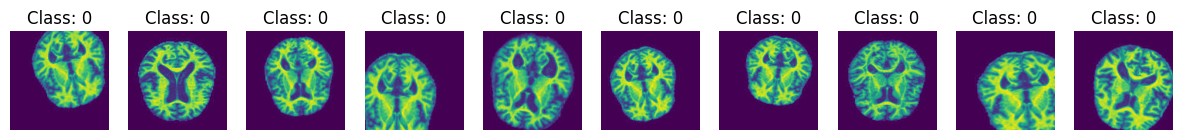

In [34]:
show_sample_images(final_dataset_merged, 10)

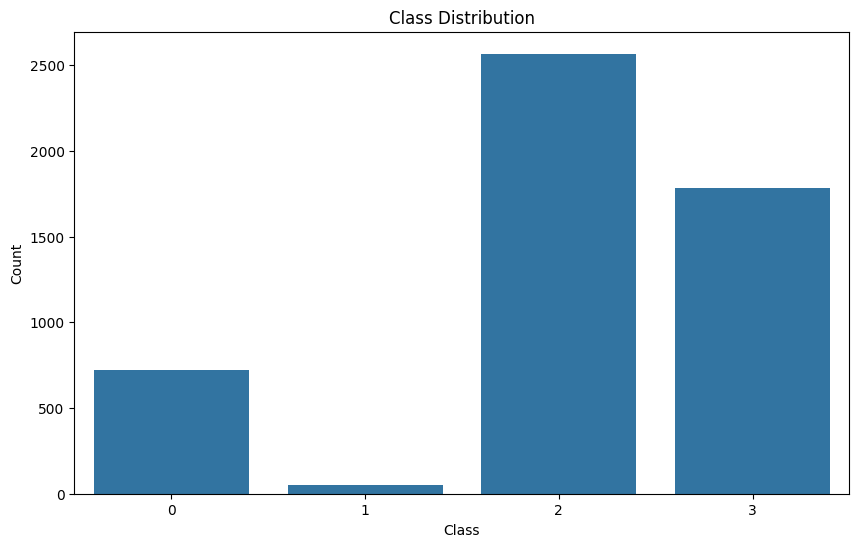

{0: 724, 1: 49, 2: 2566, 3: 1781}

In [35]:
analyze_class_distribution(data_train)

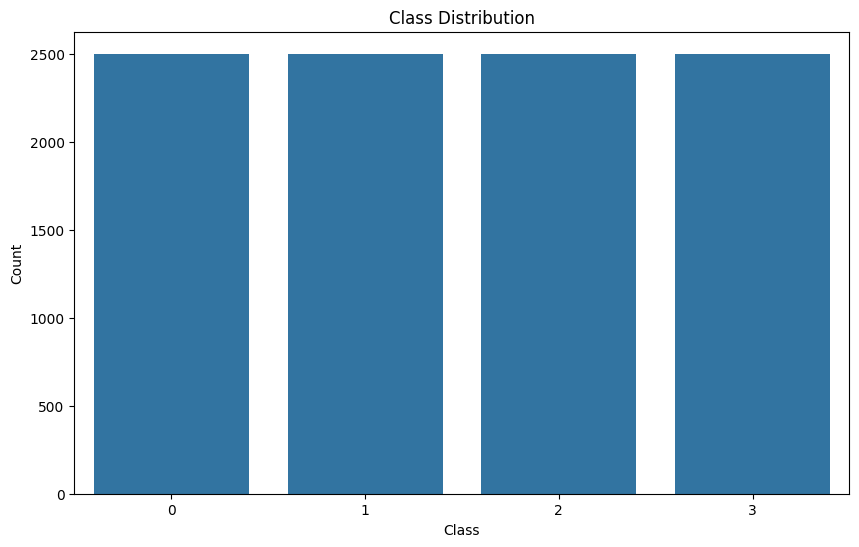

{0: 2500, 1: 2500, 2: 2500, 3: 2500}

In [36]:
analyze_class_distribution(final_dataset_merged)

Для ускорени обработки изображений и вычисления статистик, ранодомно выбираем 3000 изображений из финального датасета

In [52]:
def analyze_tensor_dataset(dataset, num_samples=3000):

    # 1. Basic Dataset Information
    print(f"Dataset size: {len(dataset)}")
    image = dataset[0]['image']
    # Open the image from bytes using io.BytesIO
    image = Image.open(io.BytesIO(image))
    print(f"Sample shape: {image.size}")


    # Get random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    images = []
    labels = []
    for idx in indices:
        img, label = dataset[idx]['image'], dataset[idx]['label']
        # Open the image from bytes using io.BytesIO before applying ToTensor
        img = Image.open(io.BytesIO(img))
        img = transforms.ToTensor()(img)
        images.append(img)
        labels.append(label)

    # Stack tensors
    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels)

    # 2. Basic Statistical Analysis
    def analyze_tensor_statistics(images_tensor):
        # Convert to numpy for analysis
        images_np = images_tensor.numpy()

        # Calculate basic statistics
        mean_per_channel = np.mean(images_np, axis=(0, 2, 3))
        std_per_channel = np.std(images_np, axis=(0, 2, 3))
        min_per_channel = np.min(images_np, axis=(0, 2, 3))
        max_per_channel = np.max(images_np, axis=(0, 2, 3))

        # Plot intensity distribution
        plt.figure(figsize=(15, 5))
        for i in range(images_np.shape[1]):
            plt.subplot(1, 3, i+1)
            plt.hist(images_np[:, i, :, :].ravel(), bins=50, alpha=0.7)
            plt.title(f'Channel {i} Intensity Distribution')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig('intensity_distribution.png')
        plt.close()

        return {
            'mean': mean_per_channel,
            'std': std_per_channel,
            'min': min_per_channel,
            'max': max_per_channel
        }

    stats = analyze_tensor_statistics(images_tensor)
    print("\nChannel Statistics:")
    print(f"Mean per channel: {stats['mean']}")
    print(f"Std per channel: {stats['std']}")
    print(f"Min per channel: {stats['min']}")
    print(f"Max per channel: {stats['max']}")

    # 3. PCA Analysis
    def perform_pca_analysis(images_tensor, n_components=50):
        # Reshape images for PCA
        X = images_tensor.numpy().reshape(len(images_tensor), -1)

        # Perform PCA
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        # Visualize first few principal components
        plt.figure(figsize=(15, 5))
        for i in range(min(3, n_components)):
            plt.subplot(1, 3, i+1)
            component = pca.components_[i].reshape(images_tensor.shape[1:])
            plt.imshow(np.transpose(component, (1, 2, 0)), cmap='viridis')
            plt.title(f'PC {i+1}')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('pca_components.png')
        plt.close()
        plt.show()

        return X_pca, pca

    X_pca, pca = perform_pca_analysis(images_tensor)

    # 4. Class Distribution Analysis (if labels are available)
    def analyze_class_distribution(labels_tensor):
        unique_labels, counts = torch.unique(labels_tensor, return_counts=True)

        plt.figure(figsize=(10, 5))
        plt.bar(unique_labels.numpy(), counts.numpy())
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.savefig('class_distribution.png')
        plt.close()

        return unique_labels, counts

    unique_labels, counts = analyze_class_distribution(labels_tensor)
    print("\nClass Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Class {label}: {count}")

# Run the analysis
analyze_tensor_dataset(final_dataset_merged)

Dataset size: 10000
Sample shape: (128, 128)

Channel Statistics:
Mean per channel: [0.28437617]
Std per channel: [0.33275214]
Min per channel: [0.]
Max per channel: [1.]

Class Distribution:
Class 0: 733
Class 1: 776
Class 2: 751
Class 3: 740


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Видим, что распределение классов остается равномерном даже на выборке. Датасет сбалансирован. Ниже представлена визуализация посчитанных данных.

Mean image для каждого класса

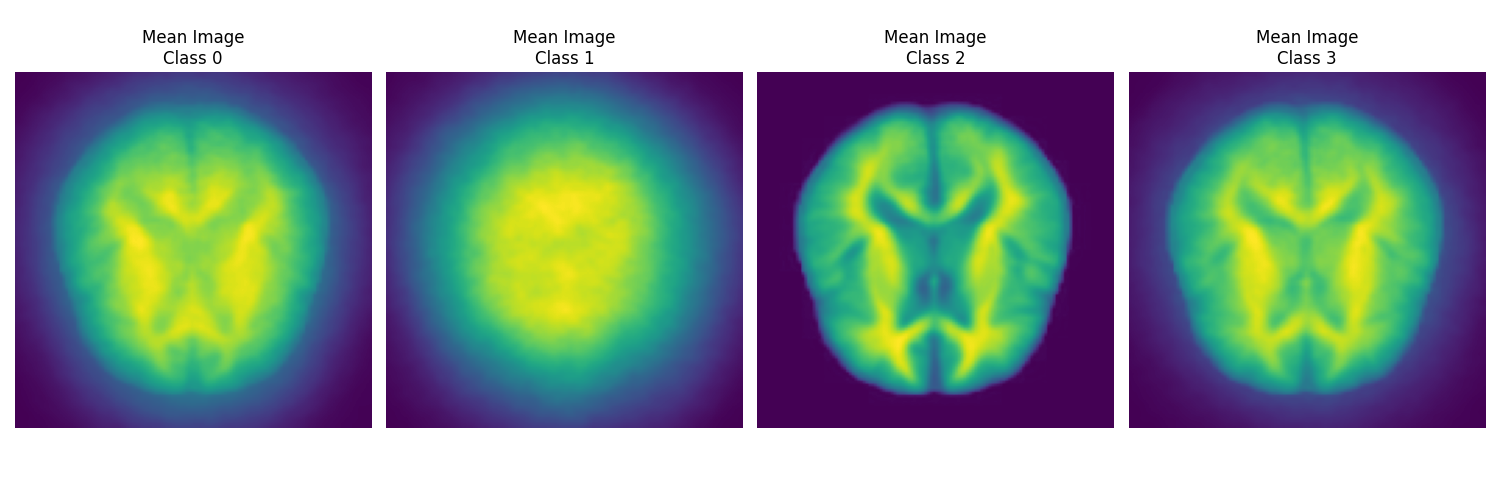

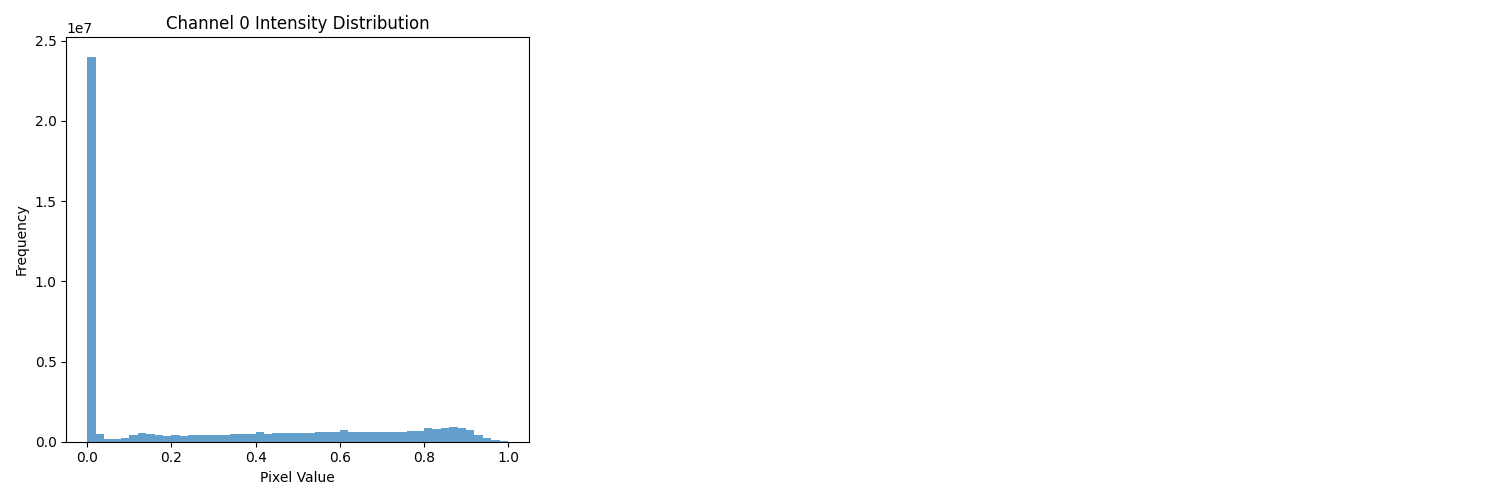


3 Principle Components

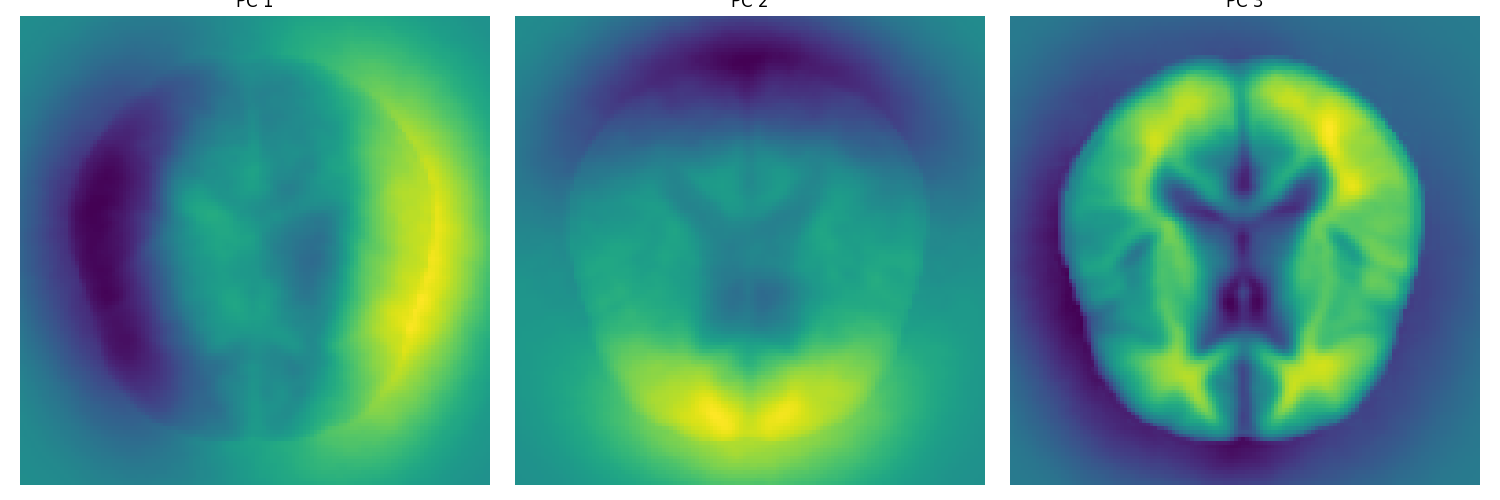

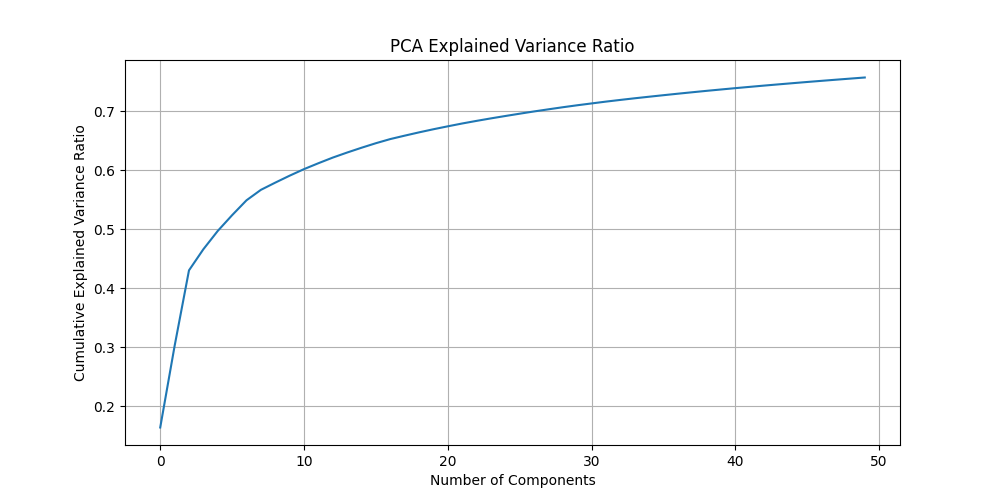

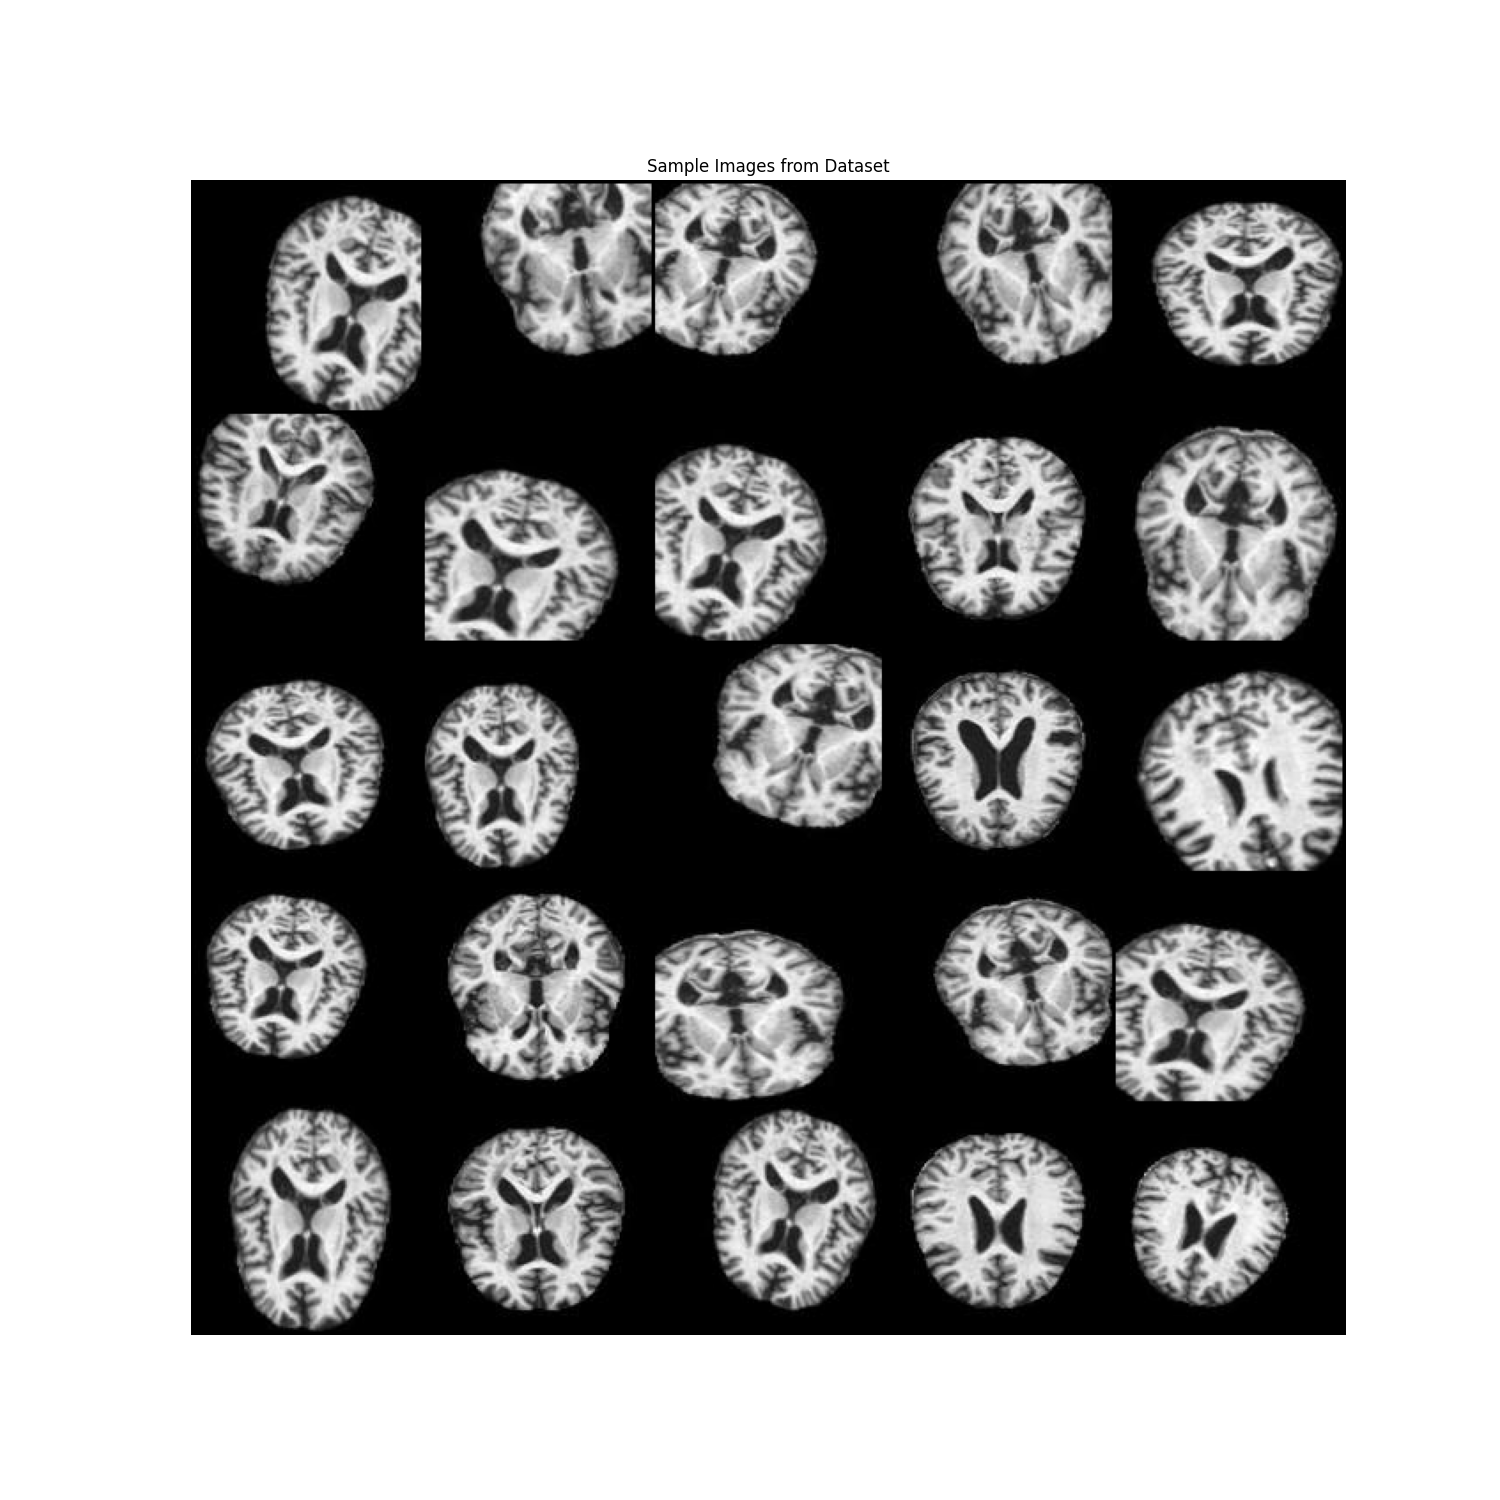

# Обеспечение качества данных

В данном случае, нам важно чтобы новые данные не сильно отличались по цвету, контрастности и структуре (так как модель потенциально может переобучиться на этих признаках и присвоить их конкретному классу). Другими словами, нам важно понимать, что новые данные стандартизированного формата для МРТ изображений.

Используем Histogram-Based Similarity

Этот метод сравнивает распределение цвета между двумя изображениями, используя их хистограммы.

In [54]:
# Get 2 random indices
num_samples = 2
random_indices = random.sample(range(len(final_dataset_merged)), num_samples)

# Select samples using the random indices
random_samples = [final_dataset_merged[i] for i in random_indices]

# Access the images and labels
imageA = np.array(Image.open(io.BytesIO(random_samples[0]['image']))) # при загрузке новых данных здесь будет изображение из нового датасета
imageB = np.array(Image.open(io.BytesIO(random_samples[1]['image'])))

In [55]:
def compare_histograms(imageA, imageB):
    histA = cv2.calcHist([imageA], [0], None, [256], [0, 256])
    histB = cv2.calcHist([imageB], [0], None, [256], [0, 256])

    # Normalize histograms
    histA = cv2.normalize(histA, histA).flatten()
    histB = cv2.normalize(histB, histB).flatten()

    # Compare using correlation
    correlation = cv2.compareHist(histA, histB, cv2.HISTCMP_CORREL)
    return correlation

correlation = compare_histograms(imageA, imageB)

print("Histogram Correlation:", correlation)
if correlation < 0.8:
    print("Images are different from the dataset and might affect quality of data")
else:
    print("Images are similar, they can be added to existing dataset")

Histogram Correlation: 0.99981578340855
Images are similar, they can be added to existing dataset


Видим, что изображения практически идентичны. Так как мы работаем со сканами головного мозга, установим высоки трешхолд в 0.8. В случае, если похожесть ниже, новые данные необходимо перепроверить

Также используем Structural Similarity Index (SSIM)

измеряет близость (похожесть) между двумя избраениями, основываясь на свете, контрастности, структуре изображения.

In [58]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(imageA, imageB):
    return ssim(imageA, imageB, multichannel=True)

ssim_value = calculate_ssim(imageA, imageB)

print("SSIM:", ssim_value)
if ssim_value < 0.8:
    print("Images are similar, they can be added to existing dataset")
else:
    print("Images are different from the dataset and might affect quality of data")


SSIM: 0.30529279399582493
Images are similar, they can be added to existing dataset
